<a href="https://colab.research.google.com/github/sritwisha/2053_DAUP/blob/main/daup_img_53.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow scikit-learn matplotlib seaborn scipy

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
dataset_zip_path = '/content/drive/MyDrive/archive (14).zip'
extract_path = '/content/dataset'

In [ ]:
import zipfile
with zipfile.ZipFile(dataset_zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
img_height, img_width = 224, 224
batch_size = 32
epochs = 5  # increase for full training

In [ ]:
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_data = datagen.flow_from_directory(
    extract_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    subset='training',
    class_mode='categorical'
)

val_data = datagen.flow_from_directory(
    extract_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    subset='validation',
    class_mode='categorical'
)

class_names = list(train_data.class_indices.keys())
num_classes = len(class_names)
print("Classes:", class_names)

Found 3502 images belonging to 4 classes.
Found 874 images belonging to 4 classes.
Classes: ['paper', 'rock', 'rps-cv-images', 'scissors']


In [ ]:
base_model = MobileNetV2(include_top=False, input_shape=(img_height, img_width, 3), weights='imagenet')
base_model.trainable = False

In [ ]:
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dense(num_classes, activation='softmax')
])

In [ ]:
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
# Train model
history = model.fit(train_data, epochs=epochs, validation_data=val_data)

# Evaluate model
val_loss, val_acc = model.evaluate(val_data)
print(f'Validation Accuracy: {val_acc:.2f}')

# Predict
predictions = model.predict(val_data)
y_true = val_data.classes
y_pred = np.argmax(predictions, axis=1)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
110/110 ━━━━━━━━━━━━━━━━━━━━ 203s 2s/step - accuracy: 0.4975 - loss: 1.0493 - val_accuracy: 0.1705 - val_loss: 1.2516
Epoch 2/5
110/110 ━━━━━━━━━━━━━━━━━━━━ 240s 2s/step - accuracy: 0.5386 - loss: 0.7441 - val_accuracy: 0.2883 - val_loss: 1.1109
Epoch 3/5
110/110 ━━━━━━━━━━━━━━━━━━━━ 193s 2s/step - accuracy: 0.5435 - loss: 0.7312 - val_accuracy: 0.3844 - val_loss: 1.0605
Epoch 4/5
110/110 ━━━━━━━━━━━━━━━━━━━━ 195s 2s/step - accuracy: 0.5382 - loss: 0.7068 - val_accuracy: 0.1979 - val_loss: 0.8996
Epoch 5/5
110/110 ━━━━━━━━━━━━━━━━━━━━ 206s 2s/step - accuracy: 0.5574 - loss: 0.6959 - val_accuracy: 0.2231 - val_loss: 0.8447
28/28 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.2278 - loss: 0.8509
Validation Accuracy: 0.22
28/28 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step


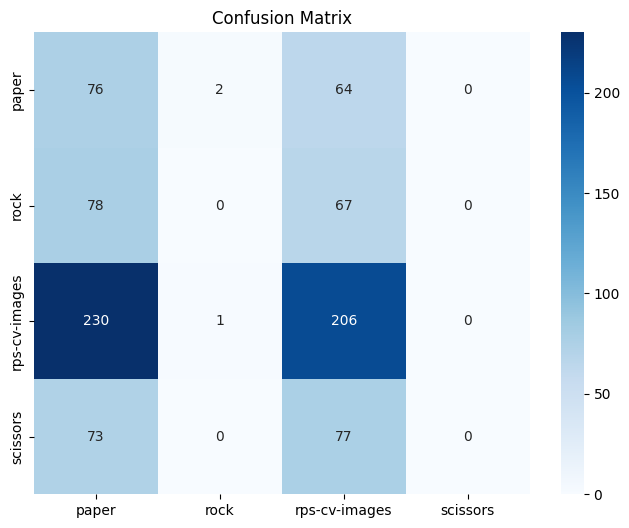

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Classification Report
print(classification_report(y_true, y_pred, target_names=class_names))

               precision    recall  f1-score   support

        paper       0.17      0.54      0.25       142
         rock       0.00      0.00      0.00       145
rps-cv-images       0.50      0.47      0.48       437
     scissors       0.00      0.00      0.00       150

     accuracy                           0.32       874
    macro avg       0.17      0.25      0.18       874
 weighted avg       0.28      0.32      0.28       874



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Z-Test & T-Test
class1_scores = predictions[val_data.classes == 0][:, 0]
class2_scores = predictions[val_data.classes == 1][:, 1]

z_stat, z_pval = stats.ttest_ind(class1_scores, class2_scores, equal_var=False)
print(f"Z-Test p-value: {z_pval:.4f}")

t_stat, t_pval = stats.ttest_ind(class1_scores, class2_scores)
print(f"T-Test p-value: {t_pval:.4f}")

Z-Test p-value: 0.0000
T-Test p-value: 0.0000


In [ ]:
anova_pval = stats.f_oneway(*[predictions[val_data.classes == i][:, i] for i in range(num_classes)]).pvalue
print(f"ANOVA p-value: {anova_pval:.4f}")
print(f"ANOVA p-value: {anova_pval:.4f}")

ANOVA p-value: 0.0000
ANOVA p-value: 0.0000


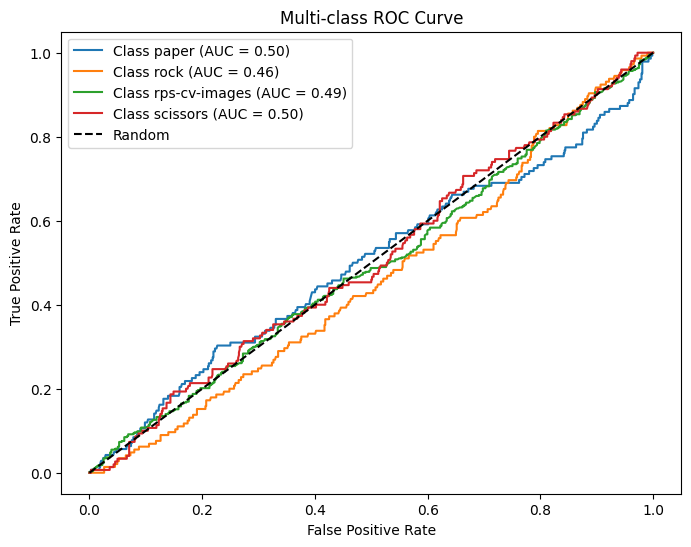

In [ ]:
# ROC Curve (One-vs-Rest)
y_test_bin = label_binarize(y_true, classes=range(num_classes))
fpr, tpr, roc_auc = {}, {}, {}
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8,6))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {class_names[i]} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.title('Multi-class ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

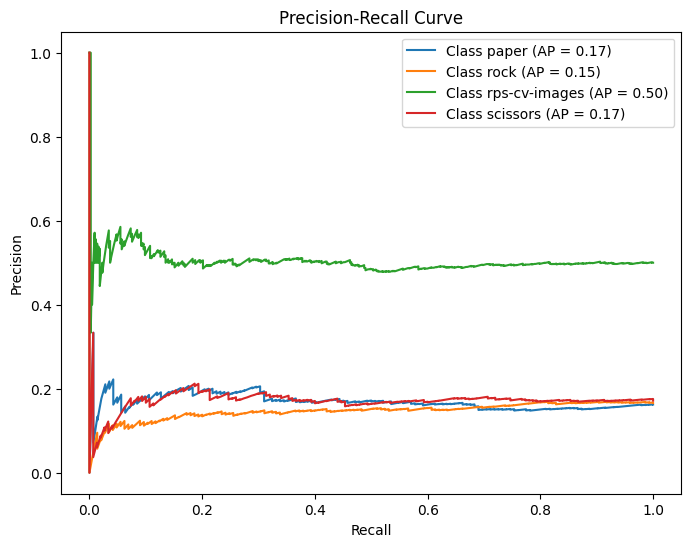

In [ ]:
# Precision-Recall Curve
average_precision = {}
plt.figure(figsize=(8,6))
for i in range(num_classes):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], predictions[:, i])
    average_precision[i] = average_precision_score(y_test_bin[:, i], predictions[:, i])
    plt.plot(recall, precision, label=f'Class {class_names[i]} (AP = {average_precision[i]:.2f})')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

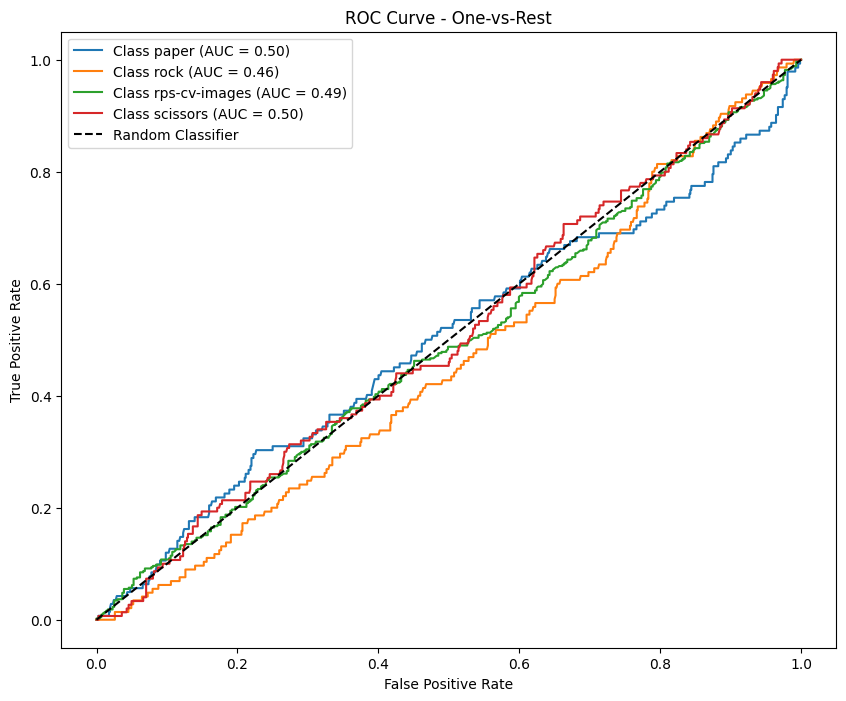

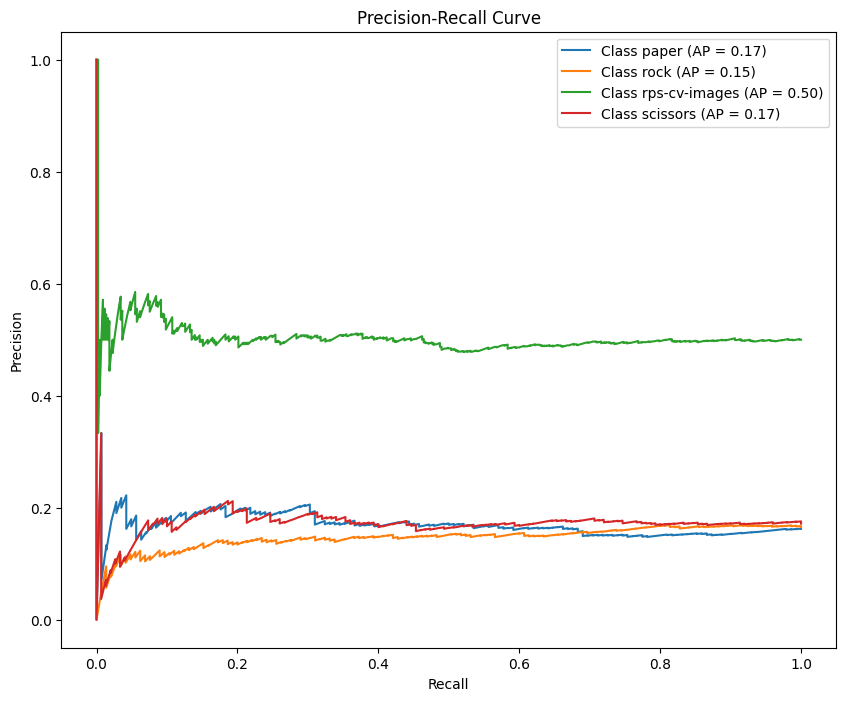

Type 1 Error (False Positive Rate): 0.52
Type 2 Error (False Negative Rate): 0.46
Mean Average Precision (mAP): 0.25


In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

# Binarize labels for ROC & PR curve
y_true_bin = label_binarize(y_true, classes=range(num_classes))
y_pred_bin = predictions

# Compute ROC Curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC Curves
plt.figure(figsize=(10, 8))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {class_names[i]} (AUC = {roc_auc[i]:.2f})')
# Random classifier line
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - One-vs-Rest')
plt.legend()
plt.show()

# Precision-Recall Curve
precision = dict()
recall = dict()
average_precision = dict()
for i in range(num_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_true_bin[:, i], y_pred_bin[:, i])
    average_precision[i] = average_precision_score(y_true_bin[:, i], y_pred_bin[:, i])

# Plot Precision-Recall Curves
plt.figure(figsize=(10, 8))
for i in range(num_classes):
    plt.plot(recall[i], precision[i], label=f'Class {class_names[i]} (AP = {average_precision[i]:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

# Type 1 and Type 2 Errors (for binary example)
# If multi-class, pick one class to show as example
from sklearn.metrics import confusion_matrix

example_class = 0  # for example, class 0
y_true_binary = (y_true == example_class).astype(int)
y_pred_binary = (y_pred == example_class).astype(int)
cm_bin = confusion_matrix(y_true_binary, y_pred_binary)
TN, FP, FN, TP = cm_bin.ravel()

print(f"Type 1 Error (False Positive Rate): {FP/(FP+TN):.2f}")
print(f"Type 2 Error (False Negative Rate): {FN/(FN+TP):.2f}")

# Mean Average Precision (mAP)
mAP = np.mean(list(average_precision.values()))
print(f"Mean Average Precision (mAP): {mAP:.2f}")